In [1]:
import librosa
import pandas as pa
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

In [2]:
def frame(data, window_length, hop_length):
    num_samples = data.shape[0]
    num_frames = 1 + int(np.floor((num_samples - window_length) / hop_length))
    shape = (num_frames, window_length) + data.shape[1:]
    strides = (data.strides[0] * hop_length,) + data.strides
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

In [3]:
EXAMPLE_WINDOW_SECONDS = .1  
EXAMPLE_HOP_SECONDS = EXAMPLE_WINDOW_SECONDS     # overlap
sampleRate_n = 48000

def getFrontBackAudio(use_i):
    use_dn = "data/data_frames/data_capture_" + str(use_i)
    wav_fn = use_dn + "/audio_data.wav"
    x, fs = librosa.load(wav_fn, sr = sampleRate_n, mono = False)
    x_front, x_back = x[0], x[1]
    return x_front, x_back

def getFrontBackFrame(x_front, x_back):
    window_length = int(round(EXAMPLE_WINDOW_SECONDS * sampleRate_n))
    hop_length = int(round(EXAMPLE_HOP_SECONDS * sampleRate_n))

    back_frames = frame(x_back,window_length,hop_length)
    front_frames = frame(x_front,window_length,hop_length)
    return front_frames, back_frames

def getDelay(front_frames, back_frames):
    frame_n = back_frames.shape[0]
    delay_d = {}
    for i in range(frame_n):
        back_frame = back_frames[i,:]
        back_pad = np.concatenate((back_frame,np.zeros(back_frame.shape)),axis=0)
        front_frame = front_frames[i,:]
        front_pad = np.concatenate((front_frame,np.zeros(front_frame.shape)),axis=0)
        corr_cross = np.fft.ifft(np.fft.fft(front_pad)*np.fft.fft(back_pad[::-1]))
        corr_mag = np.abs(corr_cross)
        corr_argmax = np.argmax(corr_mag)
        delay_d[i] = corr_argmax
    return delay_d

def getFilteredDelay(delay_d):
    delay_sz = pa.Series(delay_d)
    window_size= 3
    filt_sz = pa.Series(signal.medfilt(delay_sz, window_size))
    filt_sz = pa.DataFrame(filt_sz).rolling(window=30).mean()
    return filt_sz

In [4]:
def plotDelay(use_i):
    x_front, x_back = getFrontBackAudio(use_i)
    front_frames, back_frames = getFrontBackFrame(x_front, x_back)
    delay_d = getDelay(front_frames, back_frames)
    delay_sz = pa.Series(delay_d)
    delay_x = delay_sz.index*EXAMPLE_WINDOW_SECONDS
    filt_sz = getFilteredDelay(delay_d)
    
    plt.figure(figsize = (18, 2))
    plt.grid()
    plt.xticks(np.arange(min(delay_x), max(delay_x)+1, 5.0),rotation=90);
    plt.plot(delay_x, filt_sz, linewidth=3)
    plt.title(use_i)
    pass

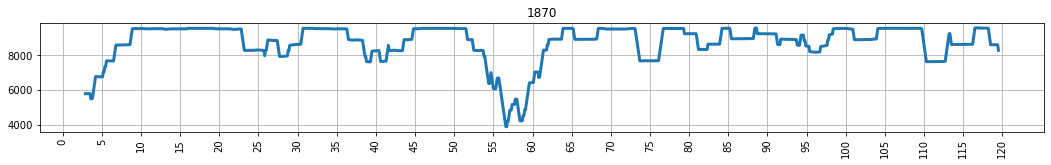

In [5]:
plotDelay(1870)

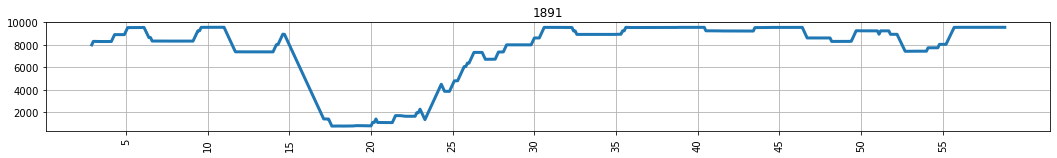

In [15]:
plotDelay(1891)

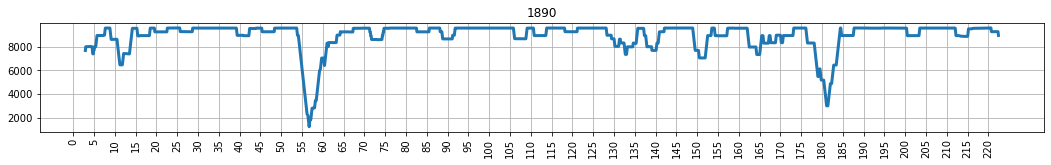

In [17]:
plotDelay(1890)

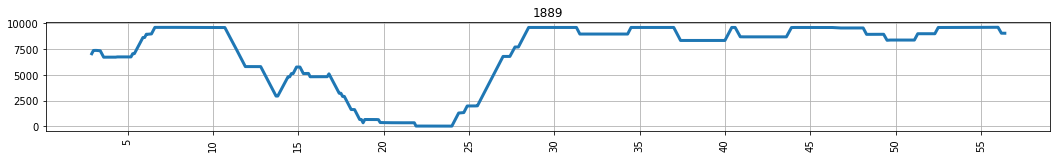

In [16]:
plotDelay(1889)

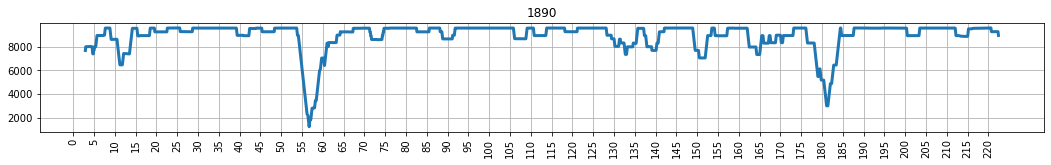

In [12]:
plotDelay(1890)